In [6]:
import pandas as pd
import numpy as np
import os 
import glob, os
from scipy import stats
#from geopy.distance import great_circle
#from geopy.distance import geodesic
#import geopandas
#import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:

#Get 2019,2020 citibike into dataframes

df_bike_list_2020=[]
for filename in glob.iglob('citibike/2020/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2020.append(pd.read_csv(filename))
        
        
df_bike_list_2019=[]
for filename in glob.iglob('citibike/2019/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2019.append(pd.read_csv(filename))
        


In [3]:
bike_2020_df = pd.concat(df_bike_list_2020)
bike_2019_df = pd.concat(df_bike_list_2019)

In [17]:


#Get 2019,2020 MTA into dataframes

df_list_2020=[]
for filename in glob.iglob('turnstile_mta/2020/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2020.append(pd.read_csv(filename))
        
        
df_list_2019=[]
for filename in glob.iglob('turnstile_mta/2019/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2019.append(pd.read_csv(filename))
        




In [18]:
mta_2020_df = pd.concat(df_list_2020)
mta_2019_df = pd.concat(df_list_2019)



In [ ]:
#bike_2019_df["DATE_TIME"]= pd.to_datetime(bike_2019_df["starttime"])
#bike_2020_df["DATE_TIME"]=  pd.to_datetime(bike_2020_df["starttime"])

In [22]:
def clean_mta(turnstiles_df):
    """
    Converts input MTA data from total cumulative counts per 
    turnstile to new entries and exits at the time of each record. 
    Also adds datetime.
    
    
    """
    
    #convert column names to lower case and eliminate trailing spaces
    turnstiles_df.columns = map(lambda x: x.lower().replace(' ',''),
        turnstiles_df.columns)
    
    #sort by specific turnstiles and add converted counts
    df = turnstiles_df.sort_values(by = ['c/a','unit','scp','station',
        'linename','date','time'])
    df['coming'] = df['entries'].diff()
    df['going'] = df['exits'].diff()
    
    #add id to identify turnstiles with one column
    df['id'] = df['c/a']+df['unit']+df['scp']+df['station']+df['linename']
    
    #eliminate edges between different turnstiles
    mask = (df.id == df.id.shift(1)) & (df.id == df.id.shift(-1))
    df[['coming', 'going']] = df[['coming','going']].where(mask,
        other=np.nan)
    
    def rollover_correcter(value):
        #normal/possible values
        if 0 < value < 5000:
            return value
        #correct for turnstiles that are running backwards
        elif -5000 < value < 0:
            return -value
        #correct for turnstiles that have rolled over
        elif -2147483647 <= value < -2147478647:
            return value+2147483647
        #correct for backwards turnstiles that have rolled over
        elif 2147478647 < value <= 2147483647:
            return 2147483647-value
        #throw out unknown issues
        else:
            return np.nan
    
    df['entries'] = df.coming.apply(rollover_correcter)
    df['exits'] = df.going.apply(rollover_correcter)
    df.dropna(inplace=True)
    df['datetime'] = pd.to_datetime(df['date']+' '+df['time'])
    df.drop('coming', axis=1, inplace=True)
    df.drop('going', axis=1, inplace=True)
    df.drop('id', axis=1, inplace=True)
    return df

In [23]:
cleaned_mta_2019 = clean_mta(mta_2019_df)
cleaned_mta_2020 = clean_mta(mta_2020_df)

In [25]:
import pickle

with open('cleaned_mta_2019', 'wb') as to_write:
    pickle.dump(cleaned_mta_2019, to_write)
    
with open('cleaned_mta_2020', 'wb') as to_write:
    pickle.dump(cleaned_mta_2020, to_write)

In [7]:
with open('cleaned_mta_2019','rb') as read_file:
    cleaned_mta_2019 = pickle.load(read_file)
    
with open('cleaned_mta_2020','rb') as read_file:
    cleaned_mta_2020 = pickle.load(read_file)

In [8]:
def mta_by_time(df,interval,year):
    df['day'] = df['datetime'].dt.dayofyear
    df['week'] = df['datetime'].dt.week
    df['month'] = df['datetime'].dt.month_name()
    df['year'] = df['datetime'].dt.year
    df['weekday'] = df['datetime'].dt.day_name()
    if interval == 'day': group = ['year','day']
    if interval == 'weekday': group = ['weekday']
    if interval == 'month': group = ['year','month']
    if interval == 'year': group = ['year']
    if str(year) == 'any':
        return df.groupby(group)[['entries']].sum().reset_index()
    else:
        new_df = df.groupby(group)[['entries']].sum().reset_index()
        new_df = new_df[new_df['year'] == year].reset_index()
        return new_df.drop(columns=['year','index'])

In [9]:
daily = mta_by_time(cleaned_mta_2019,'day',2019)
daily.columns = ['day_of_year','2019_MTA_entries']
daily['2020_MTA_entries'] = mta_by_time(cleaned_mta_2020,'day',2020)['entries']
daily['2020_as_proportion_of_2019']=daily['2020_MTA_entries']/daily['2019_MTA_entries']
daily.dropna(inplace=True)
daily

,day_of_year,2019_MTA_entries,2020_MTA_entries,2020_as_proportion_of_2019
0,1,2024689.0,2082249.0,1.028429
1,2,5286637.0,5184961.0,0.980767
2,3,5579879.0,5174092.0,0.927277
3,4,5528760.0,2969546.0,0.537109
4,5,2802319.0,2423663.0,0.864878
...,...,...,...,...
173,174,2882933.0,1018910.0,0.353428
174,175,5638605.0,1074073.0,0.190486
175,176,5820522.0,1095842.0,0.188272
176,177,6129835.0,1107756.0,0.180715


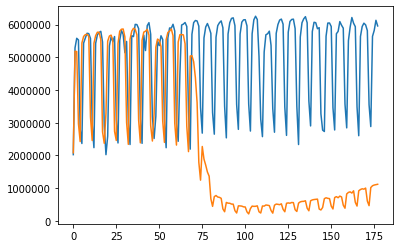

In [10]:
plt.plot(daily['2019_MTA_entries'])
plt.plot(daily['2020_MTA_entries']);

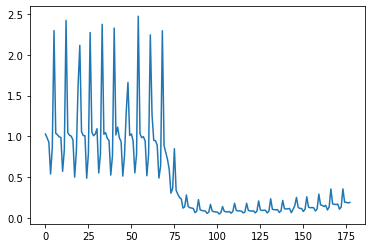

In [11]:
plt.plot(daily['2020_as_proportion_of_2019']);

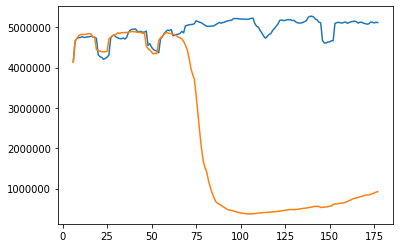

In [20]:
plt.plot(daily['2019_MTA_entries'].rolling(window=7).mean())
plt.plot(daily['2020_MTA_entries'].rolling(window=7).mean());

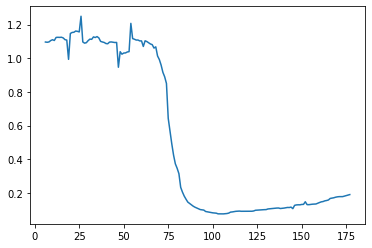

In [13]:
plt.plot(daily['2020_as_proportion_of_2019'].rolling(window=7).mean());

In [16]:
bike_2020_df['day']=pd.to_datetime(bike_2020_df['starttime']).dt.dayofyear
daily_bike=bike_2020_df.groupby(['day'])[['gender']].count().reset_index()
daily_bike.columns=['day','bike_2020']
bike_2019_df['day']=pd.to_datetime(bike_2019_df['starttime']).dt.dayofyear
daily_bike_2019=bike_2019_df.groupby(['day'])[['gender']].count().reset_index()
daily_bike['bike_2019']=daily_bike_2019['gender']
daily_bike['bike_%_of_2019']=daily_bike['bike_2020']/daily_bike['bike_2019']
daily_bike


,day,bike_2020,bike_2019,bike_%_of_2019
0,1,370,431.0,0.858469
1,2,892,827.0,1.078597
2,3,772,860.0,0.897674
3,4,566,900.0,0.628889
4,5,501,308.0,1.626623
...,...,...,...,...
147,148,1008,1150.0,0.876522
148,149,692,998.0,0.693387
149,150,770,879.0,0.875995
150,151,1718,1405.0,1.222776


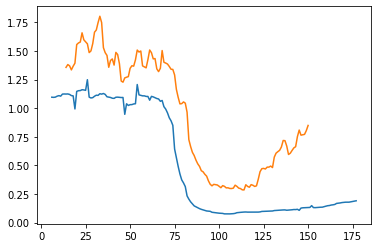

In [17]:
plt.plot(daily['2020_as_proportion_of_2019'].rolling(window=7).mean())
plt.plot(daily_bike['bike_%_of_2019'].rolling(window=15).mean());

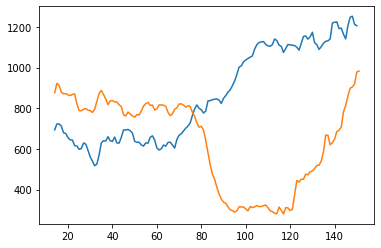

In [19]:
plt.plot(daily_bike['bike_2019'].rolling(window=15).mean())
plt.plot(daily_bike['bike_2020'].rolling(window=15).mean());

In [26]:
mta_station_names_2020 = set(cleaned_mta_2020['station'])
mta_station_names_2019 = set(cleaned_mta_2019['station'])
mta_station_names = list(mta_station_names_2020.intersection(mta_station_names_2019))
mta_by_station_2020_df = pd.DataFrame()
mta_by_station_2019_df = pd.DataFrame()
for name in mta_station_names:
    mta_by_station_2020_df[name] = cleaned_mta_2020[(cleaned_mta_2020['station'] == name) & (cleaned_mta_2020['year'] == 2020)].groupby(['day'])[['entries']].sum()['entries']
    
for name in mta_station_names:
    mta_by_station_2019_df[name] = cleaned_mta_2019[(cleaned_mta_2019['station'] == name) & (cleaned_mta_2019['year'] == 2019)].groupby(['day'])[['entries']].sum()['entries']

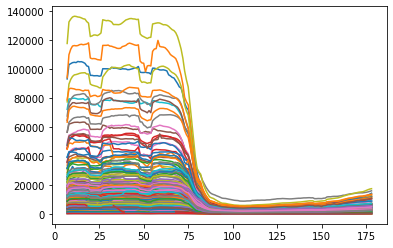

In [36]:
for name in mta_station_names:
    plt.plot(mta_by_station_2020_df[name].rolling(window=7).mean())

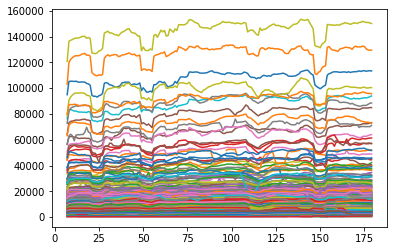

In [35]:
for name in mta_station_names:
    plt.plot(mta_by_station_2019_df[name].rolling(window=7).mean())